# Resnet Feature Output

The consistancy of the above results prompted analysis into how much processing work was left for the quantum processing unit to achieve after the data had passed through ResNet and the first linear layer. This was done by using two qubits at each processing stage, and initialising a confusion matrix after the algorithm as a whole, then replacing the quantum processing unit and last linear layer with an identity layer and initialising a confusion matrix for this new system. In this way, we are able to determine how much extra processing is achieved by the quantum processing unit, without restarting the system to eliminate the random element that might inpact this comparison. Using this method, the algorithm is not re-trained between measurements. 

In [42]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
n_qubits = 2
# Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 6              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [3]:
dev = qml.device("default.qubit", wires=n_qubits)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "./_data/hymenoptera_data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

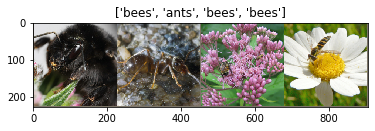

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [7]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [8]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return exp_vals

In [9]:
class PreNet(nn.Module):
    """
    Create prenet layer, which we can train and then freeze
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)

    def forward(self, input_features):
        """
        Just set through linear layer to pre_out (this will be input into quantum net)
        """
        pre_out = self.pre_net(input_features)
        
        return pre_out
    
    
    
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = input_features
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)
    
    
class DressedQuantumNet_Nlin(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
#         self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = input_features
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [10]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = PreNet()
model_hybrid.fc2 = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\miche/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


In [11]:
# model_hybrid??

In [12]:
criterion = nn.CrossEntropyLoss()

optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

In [14]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/6 Loss: 0.6855 Acc: 0.5779        
Phase: validation   Epoch: 1/6 Loss: 0.5551 Acc: 0.7582        
Phase: train Epoch: 2/6 Loss: 0.5467 Acc: 0.7295        
Phase: validation   Epoch: 2/6 Loss: 0.4413 Acc: 0.8301        
Phase: train Epoch: 3/6 Loss: 0.4937 Acc: 0.7418        
Phase: validation   Epoch: 3/6 Loss: 0.4115 Acc: 0.7778        
Phase: train Epoch: 4/6 Loss: 0.3951 Acc: 0.8689        
Phase: validation   Epoch: 4/6 Loss: 0.2929 Acc: 0.9281        
Phase: train Epoch: 5/6 Loss: 0.3737 Acc: 0.8320        
Phase: validation   Epoch: 5/6 Loss: 0.2665 Acc: 0.9346        
Phase: train Epoch: 6/6 Loss: 0.3892 Acc: 0.8402        
Phase: validation   Epoch: 6/6 Loss: 0.2614 Acc: 0.9346        
Training completed in 6m 20s
Best test loss: 0.2614 | Best test accuracy: 0.9346


# Now that we have trained the model, we want to get the output features from our reset network.

We will replace the final layer with an identity layer and then pass all the images through it, and collect the features, and labels. We can then export this into a data file to use in our kernel

In [48]:
import pandas as pd

class Identity(nn.Module):
    '''
    Identity layer, just passes outputs from prenet
    '''
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
    
# Save data to directory
directory = os.getcwd()+'/resnet_output_data'

if not os.path.exists(directory):
    os.mkdir(directory)

# Classify data using SVM

We will create an SVM model and then fit it before and after the QPU.

First do prediction with QPU then replace it with an identity layer

In [49]:
from sklearn import svm


def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 0.1, x.max() + 0.1
    y_min, y_max = y.min() - 0.1, y.max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


In [50]:
# Load data and train/validate by running through model

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True)
    for x in ["train", "validation"]
}


# We will create a pandas dataframe with a features column and a label column
train_df = pd.DataFrame(index=range(len(dataloaders['train'])), columns=['features', 'labels'])

# Add training data to 
for ix, (inputs, labels) in enumerate(dataloaders['train']):
                inputs = inputs.to(device)
                outputs = model_hybrid(inputs)
            
                # Add data to data frame
                train_df.iloc[ix].features = outputs.tolist()[0]
                train_df.iloc[ix].labels = class_names[labels.tolist()[0]]

# N
val_df = pd.DataFrame(index=range(len(dataloaders['validation'])), columns=['features', 'labels'])

for ix, (inputs, labels) in enumerate(dataloaders['validation']):
                inputs = inputs.to(device)
                outputs = model_hybrid(inputs)
            
                # Add data to data frame
                val_df.iloc[ix].features = outputs.tolist()[0]
                val_df.iloc[ix].labels = class_names[labels.tolist()[0]]

In [51]:
# Turn data into numpy arrays that are one hot encoded
X_after = np.array([d for d in train_df.features.values]).numpy()
y_after = np.array([0 if d=='bees' else 1 for d in train_df.labels.values]).numpy()

Xtest_after = np.array([d for d in val_df.features.values]).numpy()
ytest_after = np.array([0 if d=='bees' else 1 for d in val_df.labels.values]).numpy()

In [52]:
# Now fit SVM model to identity layer

# load classifier
clf_after = svm.SVC(kernel='rbf', gamma=2, C=1)
# clf = svm.SVC(kernel=my_kernel)

# Fit data
clf_after.fit(X_after, y_after)

# Predict data
ypreds_after = clf_after.predict(Xtest_after)
accuracy_after = 1-np.sum(np.abs(ypreds_after - ytest_after)/len(ytest_after))

print(accuracy_after)

0.9215686274509804


In [53]:
nb_classes = 2

confusion_matrix_tr = torch.zeros(nb_classes, nb_classes)
confusion_matrix_vl = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['train']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_tr[t.long(), p.long()] += 1

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['validation']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_vl[t.long(), p.long()] += 1



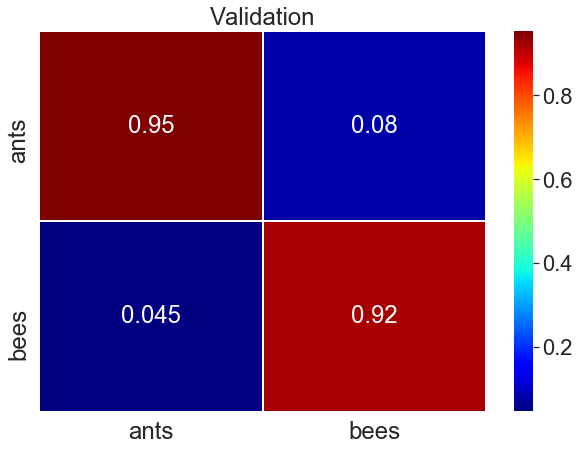

In [96]:
import seaborn as sns
cmap = 'jet'

vmin, vmax = 0.0, 80

fig = plt.figure(figsize=(10,7))

# plt.subplot(1, 2, 2)
ax1 = sns.heatmap(confusion_matrix_vl/torch.sum(confusion_matrix_vl, axis=0), 
                 cmap=cmap, 
                 annot=True, linewidth=0.5,
#                  vmin=vmin, vmax=vmax,
                 fmt='.2g',
                 annot_kws={"size": 24})


sns.set(font_scale=2) 
ax1.title.set_text('Validation')
ax1.title.set_size(24)

plt.xticks([0.5, 1.5], ['ants', 'bees'], fontsize=24)
plt.yticks([0.5, 1.5], ['ants', 'bees'], fontsize=24)

plt.show()
fig.savefig('confusion_matrix_after_QPU.png')

## Now replace QPU with identity layer

In [56]:
# Replace last layer with identity layer
model_hybrid.fc2 = Identity()

In [57]:
# Load data and train/validate by running through model

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True)
    for x in ["train", "validation"]
}


# We will create a pandas dataframe with a features column and a label column
train_df = pd.DataFrame(index=range(len(dataloaders['train'])), columns=['features', 'labels'])

# Add training data to 
for ix, (inputs, labels) in enumerate(dataloaders['train']):
                inputs = inputs.to(device)
                outputs = model_hybrid(inputs)
            
                # Add data to data frame
                train_df.iloc[ix].features = outputs.tolist()[0]
                train_df.iloc[ix].labels = class_names[labels.tolist()[0]]

# N
val_df = pd.DataFrame(index=range(len(dataloaders['validation'])), columns=['features', 'labels'])

for ix, (inputs, labels) in enumerate(dataloaders['validation']):
                inputs = inputs.to(device)
                outputs = model_hybrid(inputs)
            
                # Add data to data frame
                val_df.iloc[ix].features = outputs.tolist()[0]
                val_df.iloc[ix].labels = class_names[labels.tolist()[0]]

In [58]:
# Turn data into numpy arrays that are one hot encoded
X_before = np.array([d for d in train_df.features.values]).numpy()
y_before = np.array([0 if d=='bees' else 1 for d in train_df.labels.values]).numpy()

Xtest_before = np.array([d for d in val_df.features.values]).numpy()
ytest_before = np.array([0 if d=='bees' else 1 for d in val_df.labels.values]).numpy()

In [59]:
# Now fit SVM model to identity layer

# load classifier
clf_before = svm.SVC(kernel='rbf', gamma=2, C=1)
# clf = svm.SVC(kernel=my_kernel)

# Fit data
clf_before.fit(X_before, y_before)

# Predict data
ypreds_before = clf_before.predict(Xtest_before)
accuracy_before = 1-np.sum(np.abs(ypreds_before - ytest_before)/len(ytest_before))

print(accuracy_before)

0.9215686274509804


In [61]:
nb_classes = 2

confusion_matrix_tr = torch.zeros(nb_classes, nb_classes)
confusion_matrix_vl = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['train']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_tr[t.long(), p.long()] += 1

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['validation']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix_vl[t.long(), p.long()] += 1



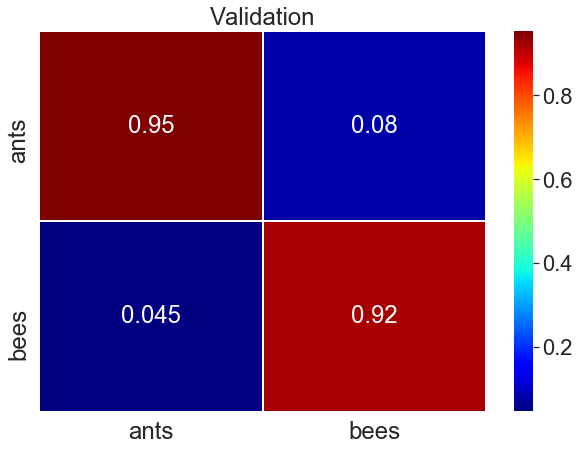

In [97]:
import seaborn as sns
cmap = 'jet'

vmin, vmax = 0.0, 80

fig = plt.figure(figsize=(10,7))

# plt.subplot(1, 2, 2)
ax1 = sns.heatmap(confusion_matrix_vl/torch.sum(confusion_matrix_vl, axis=0), 
                 cmap=cmap, 
                 annot=True, linewidth=0.5,
#                  vmin=vmin, vmax=vmax,
                 fmt='.2g',
                 annot_kws={"size": 24})


sns.set(font_scale=2) 
ax1.title.set_text('Validation')
ax1.title.set_size(24)

plt.xticks([0.5, 1.5], ['ants', 'bees'], fontsize=24)
plt.yticks([0.5, 1.5], ['ants', 'bees'], fontsize=24)

plt.show()
fig.savefig('confusion_matrix_before_QPU.png')